# 07 Dense networks
---
# Checklist
- [x] 1-layer
- [x] 2-layer

# Compared conditions with grid search,
In order to find the model that allows for the most accurate class predictiopn inswissroad datasset, I created custom grid search function that allowed to build large. umber of dense NN models with different parameters and data preprocessing steps. Subsewquently, I compared  models with the following parameters:

- __one or two hidden layers__ (1-200)
- __different batch size__
    * 10, 20, 32, 48, 64
- __three different optimizers__
    * "Adam", "SGD", "RMSprop"
- __different size of the first layer__
    * 6-600 units were tested
- __50% dropout on no dropout__
    * applied only to models with two hiddden layers, 
- __different activation functions__
    * "relu", "sigmoid" and "tanh"
    * also applied only to models with two hiddden layers, 
    
# RESULTS AND MY OBERVATIONS:

* __Model Accuracy__
    * majority of models created usning one or two layers produced relatively high validation accuracy,  >0.8, The exception were the two-layer models with small number of units at hidden layer (6), trained with 50% dropout, that were all performing worst the the rest of models (0ften >0.7 validation accuracy).
    * the summary table, displayed after the figures with model accuracy, shows clearly that two layer models allowed contructing more accurate models then one layer models. The difference is however, relatively small. The best performing two layer model produced validation accuracy 0.929, whereas the best performing one layer model 0.916.    
       
    
* __Effect of different optimizers on model accuracy__
    * it was clear that models build with "Adam" optimizer were, more often performing better then the models created with the two other optimizers, SGD or RMSprop (see summary table with best perfroming models under the main figure). Moreover, SGD optimizer required more time to train the model, then the other two optimizers.
  
  
     
* __Effect of different sizes of the hidden layer one model accuracy__   
    * I tested two layer models with 6, 36, 72 and 600 units in its hidden unit.
    * all models create with only 6 units, underperformed, in coparison to models with 72 and 600 units, whereas the models builded with 36 units produced higly performing models less often then models using layers with 72 and 600 units.   
      
    
* __batch size__
    * I evaluated each model with five different batch sizes (10, 20, 32, 48, 64)
    * In most groups, 20-64 batch size gave the best accuracy results, with larger batch size (>=32) being more optimal for models using relu or tanh activation functions, and lower batch size (20 or 32) for models using sigmoid activation function. 
    * SGD optimizer was more sensitive to batch size, then the other twom optimazers, and worked better with lower batch size, 
      
      
* __dropout__
    * all two layer models were trained with or without 50% dropout at the first hidden layer. 
    * dropout slighly imporoved the results obtained with two layer models that were constructed with at least 36 unit at its hidden layer, 
    * in contrast, dropout applied to dense networks with small number of units at the hidden layer greatly reduced model accuracy, and some model produced accuracy results >0.7 (see figures with model accuracy)  
      
    
* __activation function__
    * the models crerated with relu activation function, were performing better then the models created with sigmoig and tanh
    * the difference in model accuracy was the most visible when dropout was applied. The models with sigmoid activation function perfomed the best, followed by the models build with sigmoid and tanh activation functions,     
    * models trained with SGD optimizer and sigmoid activation function were more sensitive for batch size then the other types of two layer models, and perfomed better with low batch size, eg.10. 
       

* __loss__
    * finally, after identifying the best performign models, i examined plots with the loss and accuracy over each epoch from these models. Best performing models coul be characterized by asyptotic descrease of loss, and increase of accuracy, with valiadation accuracy just below the train accuracy, and validation loss, sligly higher then the train loss. The model, was imporving even being close to pleateau for several epoch, until ended by easrly stopping procedure. Lower of bad quality models, often showed no improvement in validation scores (accuracy and loss) whereas train scores were quikly improving (loss->0, accuracy ->1).
    


# Config

In [1]:
# ************************************************************************* #
#     Author:   Pawel Rosikiewicz                                           #       
#     Copyrith: IT IS NOT ALLOWED TO COPY OR TO DISTRIBUTE                  #
#               these file without written                                  #
#               persmission of the Author                                   #
#     Contact:  prosikiewicz@gmail.com                                      #
#                                                                           #
# ************************************************************************* #

# Config

# basedir
basedir = '/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution'

# project config
project_name = "Pawel_Rosikiewicz_EPFLext_Project4"
dataset_name = "swissroads"
subset_names = ["train", "valid", "test"]
module_names = ["imagenet"]
class_colors = {          "car": "orange",
                          "van": "steelblue",
                          "truck": "red",
                          "bike": "forestgreen",
                          "motorcycle" : "purple",
                           "other": "dimgrey"}

# task config
task_name = "dense_networks" # tranfer learning ussing 1 or 2 layed NN, and features extracted wiht tf hub
train_subset_names = ["train", "valid"] # data subsets, used together in part 1 and in part 3 for ploting image examples and PCA analyis
test_subset_names = ["test"]


# Note:
"""in some cases train, test and valid datasets, may be also subset names of the datasets, 
   this script works by loading selected daset subsets into either train and test category, 
   validation ataset is created automatically, at random fro 30% of train dataset.
   all saved predictions have reference to original images in raw data
""";

# Load packages

In [2]:
import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import pickle
import warnings
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 

from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
import graphviz # allows visualizing decision trees,

# Load custom functions created for the project from basedir/src/utils

In [3]:
os.chdir(basedir)
sys.path.append(basedir)

# my tools, loaded only form basedir, 
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.logreg_tools import my_logredCV, plot_examples_with_predictions_and_proba, plot_examples_with_predictions_and_proba_gamma
from src.utils.random_forest import random_forest_grid_search, plot_random_tree_summary_andor_table
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary
from src.utils.SVM_tools import SVM_grid_search, plot_grid_acc_and_return_summary_df
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary, model_gridsearch_summary_plots
from src.utils.knn_tools import knn_grid_search
from src.utils.dense_networks_tools import create_keras_one_layer_dense_model, create_keras_two_layer_dense_model, denseNN_grid_search, plot_NN_loss_acc

# one of my functions was generating warnign, on copies, despite using proper syntax, 
warnings.filterwarnings("ignore")

# To avoid restaring the kernel with keras, preffered solution; use conda install nomkl
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# setup paths for the task

In [4]:
PATH_raw = os.path.join(basedir, "data/raw", dataset_name)
PATH_encoded = os.path.join(basedir, "data/interim", dataset_name)
PATH_results = os.path.join(basedir, "data/results", f"{dataset_name}_{task_name}")

# create new direcory for task results, 
try: 
    os.mkdir(PATH_results)
    try:
        os.chdir(PATH_results)
        print("PATH_results was created")
    except:
        print("ERROR: PATH_results was not created correctly")
except: 
    print("file already exist, or PATH_results was not created correctly")

PATH_results was created


# Perform grid search to find best performing model and evaluate the influence of different parameters on the accuracy results
---
* The fucntion that I created allows comparing all conditions that were described in section introduction, 
* the data are loaded using custom made genberastors, keras image generators,
* train and valid data are mixed and divided again in proportion 0.7:0.3,

In [7]:
grid = ParameterGrid([
    {
        "model":["one_layer"],
        "train_test_split__train_size":[0.7], # also used for radomization in raw sample set, 
        "random_state":[0],
        # ...
        "out_activation":["softmax"],
        "optimizer":["Adam", "SGD", "RMSprop"],
        "metrics": [["acc"]],
        # ...
        'fit__batch_size' : [10, 20, 32, 48, 64],
        "EarlyStopping__patience": [5],
        "fit__epoch": [300],
        "fit__validation_split":[0.7]
    },{

        "model":["two_layers"],
        "train_test_split__train_size":[0.7], # also used for radomization in raw sample set, 
        "random_state":[0],
        # ..
        "h1_unit_size":[6, 36, 72, 600],
        "h1_Dropout" : [0, 0.5],
        "h1_activation": ["relu", "tanh", "sigmoid"],
        # ...
        "out_activation":["softmax"],
        "optimizer":["Adam", "SGD", "RMSprop"],
        "metrics": [["acc"]],
        # ...
        'fit__batch_size' : [10, 20, 32, 48, 64],
        "EarlyStopping__patience": [5],
        "fit__epoch": [300],
        "fit__validation_split": [0.7]              
    }]
)



# .. 
for module_name in module_names:
    print(f"- {module_name} -")
    print(f"{len(grid)} parameter combinations will be evaluated")
    print(f"if will take approximately {np.round(len(grid)*7/100, 1)} min")
    
    
    # run grid search, 
    dt_results_list, model_predictions_dict, model_history_dict = denseNN_grid_search(
                dataset_name = dataset_name,
                method_name = task_name,
                module_name=module_name,
                PATH_encoded=PATH_encoded,
                train_subset_names=train_subset_names,
                test_subset_names=test_subset_names,
                class_encoding=dict(zip(list(class_colors.keys()), list(range(len(class_colors))))),
                grid=grid,
                store_predictions= True,
                track_progres= True,
                verbose=False,
                plot_history=False

            )
    
    # STEP 2. save files 
    os.chdir(PATH_results)

    # .. save summary table
    pd.DataFrame(dt_results_list).to_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv", header=True)
    
    # .. save the model_predictions_dict into a pickle file
    with open(f"{task_name}__{module_name}__{dataset_name}__model_predictions_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(model_predictions_dict, file)     
        
    # .. save the model_history_dict into a pickle file
    with open(f"{task_name}__{module_name}__{dataset_name}__model_history_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(model_history_dict, file)         
        
        
print("DONE ...")

- imagenet -
375 parameter combinations will be evaluated
if will take approximately 26.2 min
imagenet _________________________________________ 2020-11-18 10:04:02.893722
.......................................................................................................................................................................................................................................................................................................................................................................................
DONE _________________________________________ 2020-11-18 10:20:01.471844

DONE ...


# Evaluate models created with grid search
---

### Show top ten best performing models
* classyfication is based on validation accuracy, 

In [8]:
# SHOW TABLE WITH 10 BEST PERFORMINGH MODELS, 
for i, module_name in enumerate(module_names):
    try:
        # reload the data
        os.chdir(PATH_results)
        one_module_summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")
        
        if i==0:
            summary_df = one_module_summary_df   
        else:
            summary_df = pd.concat([summary_df,one_module_summary_df], axis=0)
    except:
        pass
    
# sort summary table 
features_to_display = list(summary_df.columns)
features_to_display = ["model_ID", "module", "model_acc_valid", "model_acc_train", "model_acc_test"]
df_sorted = summary_df.sort_values("model_acc_valid", ascending=False).loc[:,features_to_display]
display(df_sorted.head(10))

model_ID    module  model_acc_valid  model_acc_train  model_acc_test
165       165  imagenet         0.929932           1.0000            0.96
348       348  imagenet         0.924490           0.9984            0.96
156       156  imagenet         0.923129           1.0000            0.96
120       120  imagenet         0.923129           1.0000            0.96
21         21  imagenet         0.922449           1.0000            0.94
318       318  imagenet         0.921088           1.0000            0.92
276       276  imagenet         0.921088           0.9936            0.94
216       216  imagenet         0.920408           0.9984            0.92
108       108  imagenet         0.920408           1.0000            0.96
224       224  imagenet         0.919728           0.9920            0.94

#  plot loss and accuracy values history over epoch in three best performing models

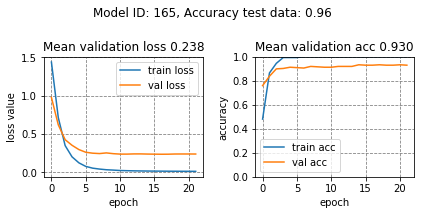

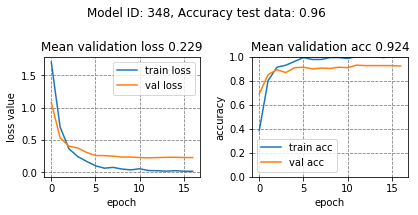

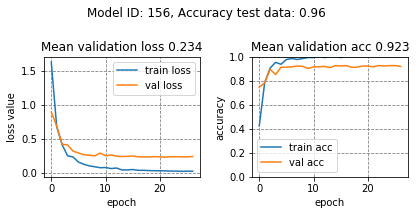

In [9]:
# .. plot loss and accuracy values history over epoch
for model_ID in df_sorted.model_ID.iloc[0:3]:
    test_acc_results = model_predictions_dict[model_ID]["test"]['acc_restuls_and_params']["model_acc_test"]        
    plot_NN_loss_acc(
        title=f"Model ID: {model_ID}, Accuracy test data: {str(np.round(test_acc_results,3))}",
        model_history_df=model_history_dict[model_ID]['model_history'], 
        n_mean=3,
        figsize=(6,3),
        top=0.75
    )

# Compare train and validation accuracy of models created using different combinations of parameters
---
* Name of each plot indicates number of layers in the fully connected network (one layer or two layers), followed by name of the activation function (relu, tanh, and sigmoig) and the drop out level applied to the firsst hidden layer in two layer models. __CAUTION__, the latter two values dfo not applied to one layer models, thus they were written as nan 
* different plots on each figure show accuracy calculated for models build with different optimizers.
* The Table below figures shows the best performing model from each plot, with relevant parameters

#### IMPORTANT : the results and my observations were placed in the first cell on that notebook

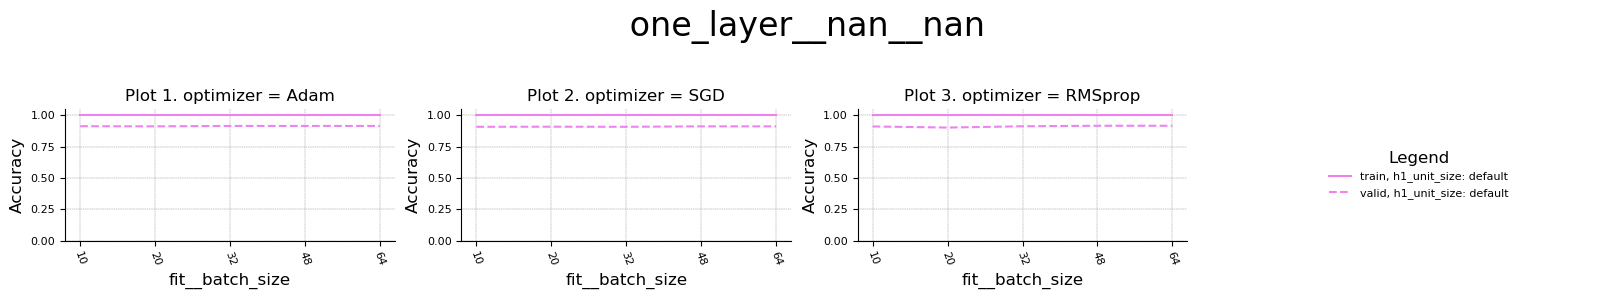

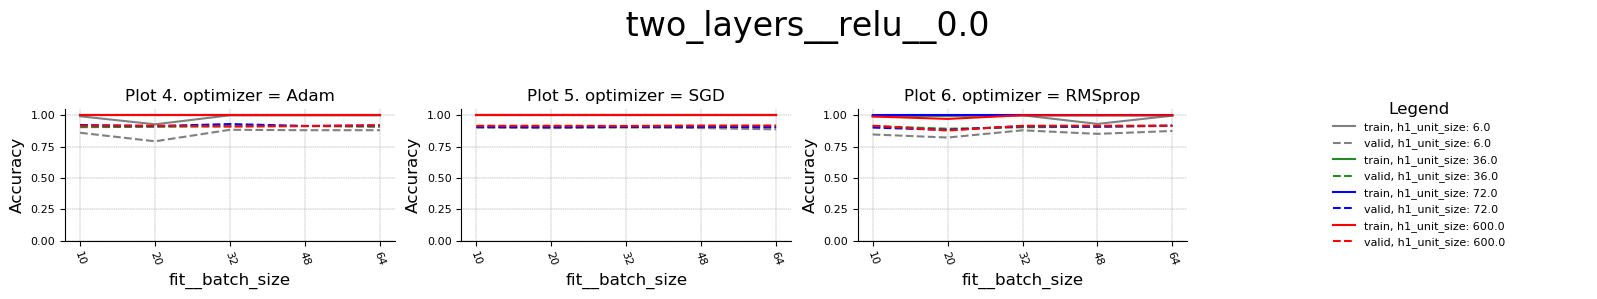

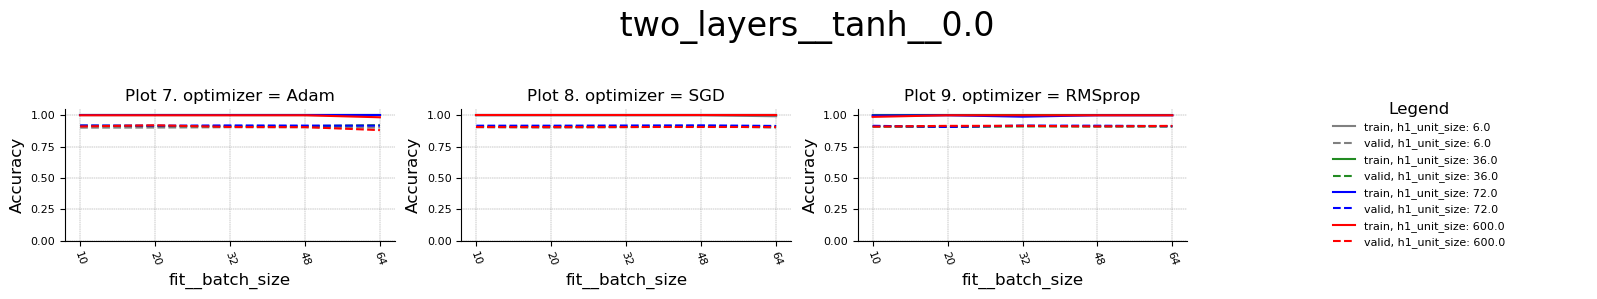

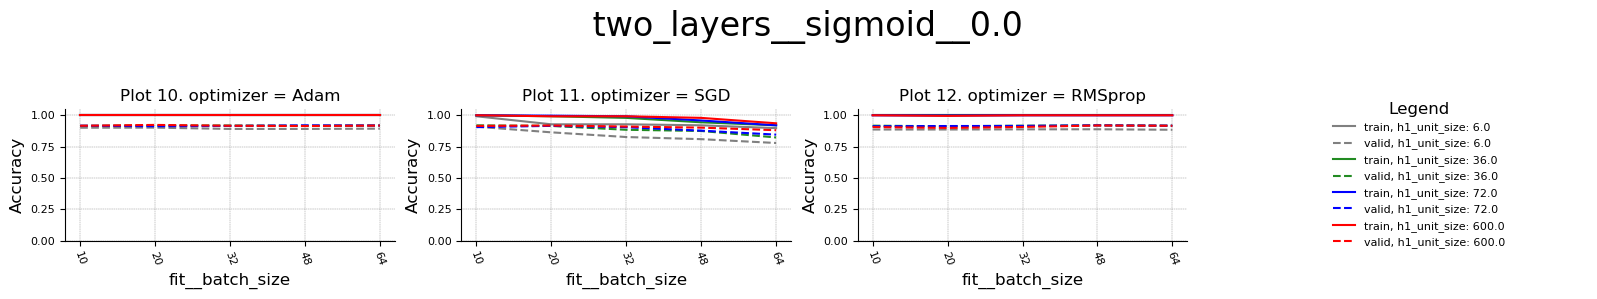

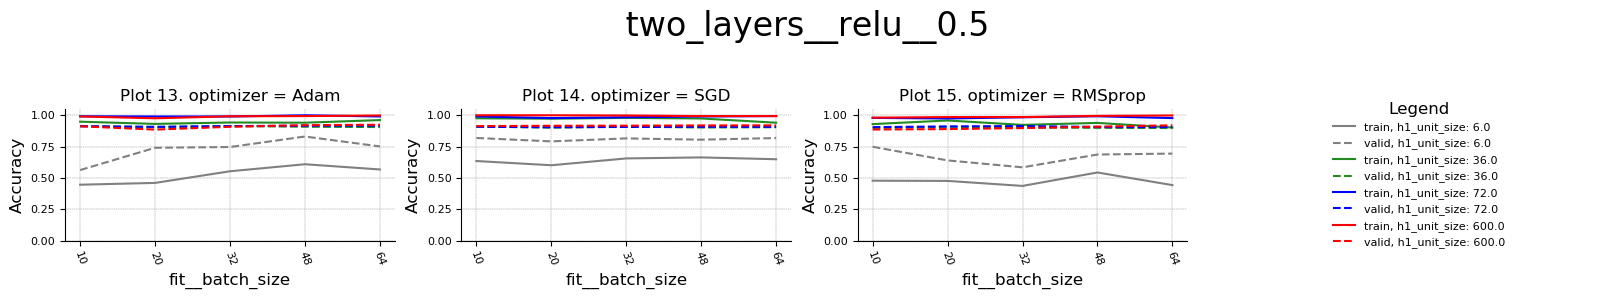

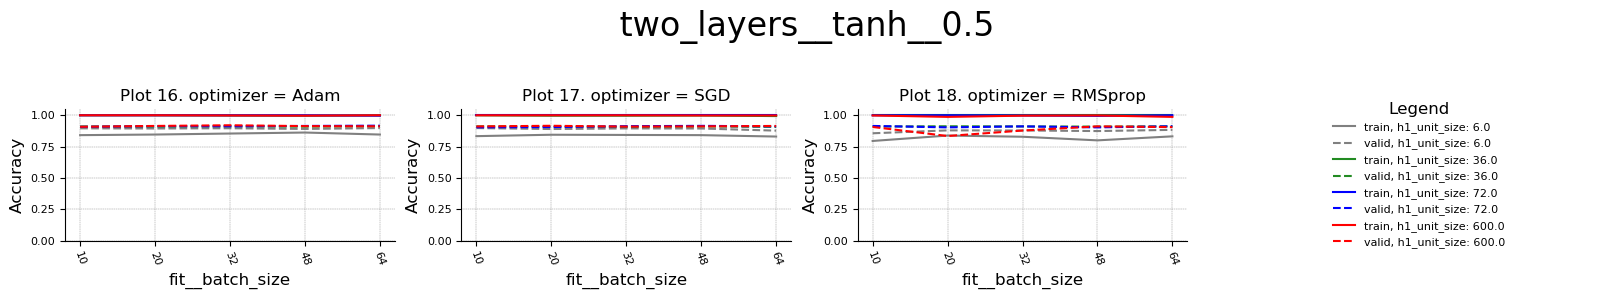

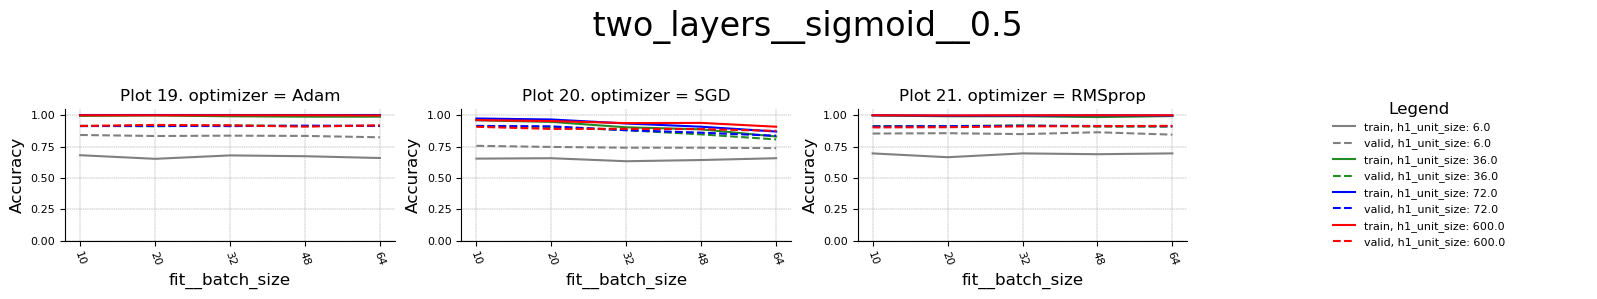

Plot_nr  model_ID          method    module  model_acc_train  \
3    Plot 4       165  dense_networks  imagenet           1.0000   
12  Plot 13       348  dense_networks  imagenet           0.9984   
18  Plot 19       156  dense_networks  imagenet           1.0000   
9   Plot 10       120  dense_networks  imagenet           1.0000   
6    Plot 7       318  dense_networks  imagenet           1.0000   
15  Plot 16       216  dense_networks  imagenet           0.9984   
20  Plot 21       224  dense_networks  imagenet           0.9920   
14  Plot 15       350  dense_networks  imagenet           0.9984   
11  Plot 12       263  dense_networks  imagenet           1.0000   
13  Plot 14       349  dense_networks  imagenet           0.9936   
10  Plot 11        43  dense_networks  imagenet           1.0000   
7    Plot 8       250  dense_networks  imagenet           1.0000   
5    Plot 6       311  dense_networks  imagenet           1.0000   
4    Plot 5       241  dense_networks  imagenet           1.0000   
8    Plot 9       179  dense_networks  imagenet           0.9888   
16  Plot 17       145  dense_networks  imagenet           1.0000   
2    Plot 3        11  dense_networks  imagenet           1.0000   
17  Plot 18        71  dense_networks  imagenet           1.0000   
19  Plot 20        79  dense_networks  imagenet           0.9600   
0    Plot 1         6  dense_networks  imagenet           1.0000   
1    Plot 2        10  dense_networks  imagenet           1.0000   

    model_acc_valid  model_acc_test                   figures optimizer  \
3          0.929932            0.96     two_layers__relu__0.0      Adam   
12         0.924490            0.96     two_layers__relu__0.5      Adam   
18         0.923129            0.96  two_layers__sigmoid__0.5      Adam   
9          0.923129            0.96  two_layers__sigmoid__0.0      Adam   
6          0.921088            0.92     two_layers__tanh__0.0      Adam   
15         0.920408            0.92     two_layers__tanh__0.5      Adam   
20         0.919728            0.94  two_layers__sigmoid__0.5   RMSprop   
14         0.919728            0.96     two_layers__relu__0.5   RMSprop   
11         0.919728            0.94  two_layers__sigmoid__0.0   RMSprop   
13         0.919728            0.96     two_layers__relu__0.5       SGD   
10         0.919728            0.94  two_layers__sigmoid__0.0       SGD   
7          0.919728            0.92     two_layers__tanh__0.0       SGD   
5          0.918367            0.96     two_layers__relu__0.0   RMSprop   
4          0.918367            0.96     two_layers__relu__0.0       SGD   
8          0.917687            0.94     two_layers__tanh__0.0   RMSprop   
16         0.916327            0.96     two_layers__tanh__0.5       SGD   
2          0.916327            0.96       one_layer__nan__nan   RMSprop   
17         0.914966            0.96     two_layers__tanh__0.5   RMSprop   
19         0.914966            0.94  two_layers__sigmoid__0.5       SGD   
0          0.914966            0.96       one_layer__nan__nan      Adam   
1          0.911565            0.94       one_layer__nan__nan       SGD   

    fit__batch_size  h1_unit_size  baseline_acc_train  baseline_acc_valid  \
3                32          72.0            0.245734            0.190476   
12               64         600.0            0.245734            0.190476   
18               20         600.0            0.245734            0.190476   
9                20         600.0            0.245734            0.190476   
6                64          36.0            0.245734            0.190476   
15               32         600.0            0.245734            0.190476   
20               32          36.0            0.245734            0.190476   
14               64         600.0            0.245734            0.190476   
11               48          72.0            0.245734            0.190476   
13               64         600.0            0.245734            0.190476   
10       

In [10]:
# plot accuracy results for models created with different parameters
for module_name in module_names:
    try: 
        # load summary data
        os.chdir(PATH_results)
        summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")
    
        # create new variable to allow displaying data in more organised way on plots
        summary_df["figures"] = [f"{x}__{y}__{z}" for x,y, z in zip(summary_df.model.values.tolist(), summary_df.h1_activation.values.tolist(), summary_df.h1_Dropout.values.tolist())]

        # restore deafult settign for matplolib 
        mpl.rcdefaults() 
        
        # summary plots and table, 
        best_performing_model_on_each_plot = model_gridsearch_summary_plots(
                data=summary_df, 
                module_names=[module_name],
                fig_title_prefix = "",
                create_figure = True,
                # ...
                fig_dname        = "figures",
                subplots_dname   = "optimizer",
                xaxis_dname      = 'fit__batch_size',
                linecolor_dname  = "h1_unit_size", # "h1_unit_size", "h1_activation", "h1_Dropout" 
                linestyle_dnames = ["train", "valid"],
                yaxis_values     = "acc",
                select_for_summary= "max",
                # ...
                figsize=(16,3),
                fontscale=0.8,
                x_label = None,
                y_label = "Accuracy",
                y_limits = (0,1.05),
                subplots_adjust_top=0.65
            )
        
        # display summary table with best poerforming models, 
        display(best_performing_model_on_each_plot.sort_values("model_acc_valid", ascending=False))
        
    except:
        pass



# Plot Predictions made with the best performing model for test data
---

* The best model was selected using validation accuracy, from all compared models in that section, 
* border colors arround each picture show true class of that image (see legend, for class-color pairs),
* the groups of images (labelled on top of each group), show classyfication made by the model,
* the probability values displayed on each image were calculated using model.predict_proba() function, 
* Predictions in each group were summarized, on pie plots below the main figure, 
* you may double click on the image to make it larger, 

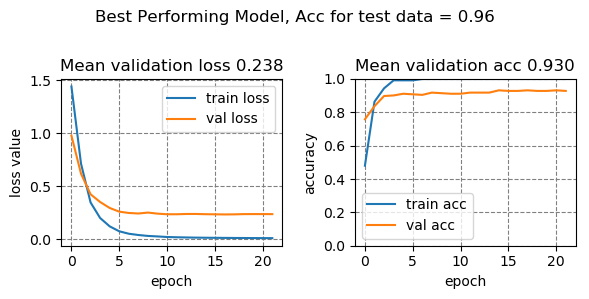

Found 50 images belonging to 6 classes.


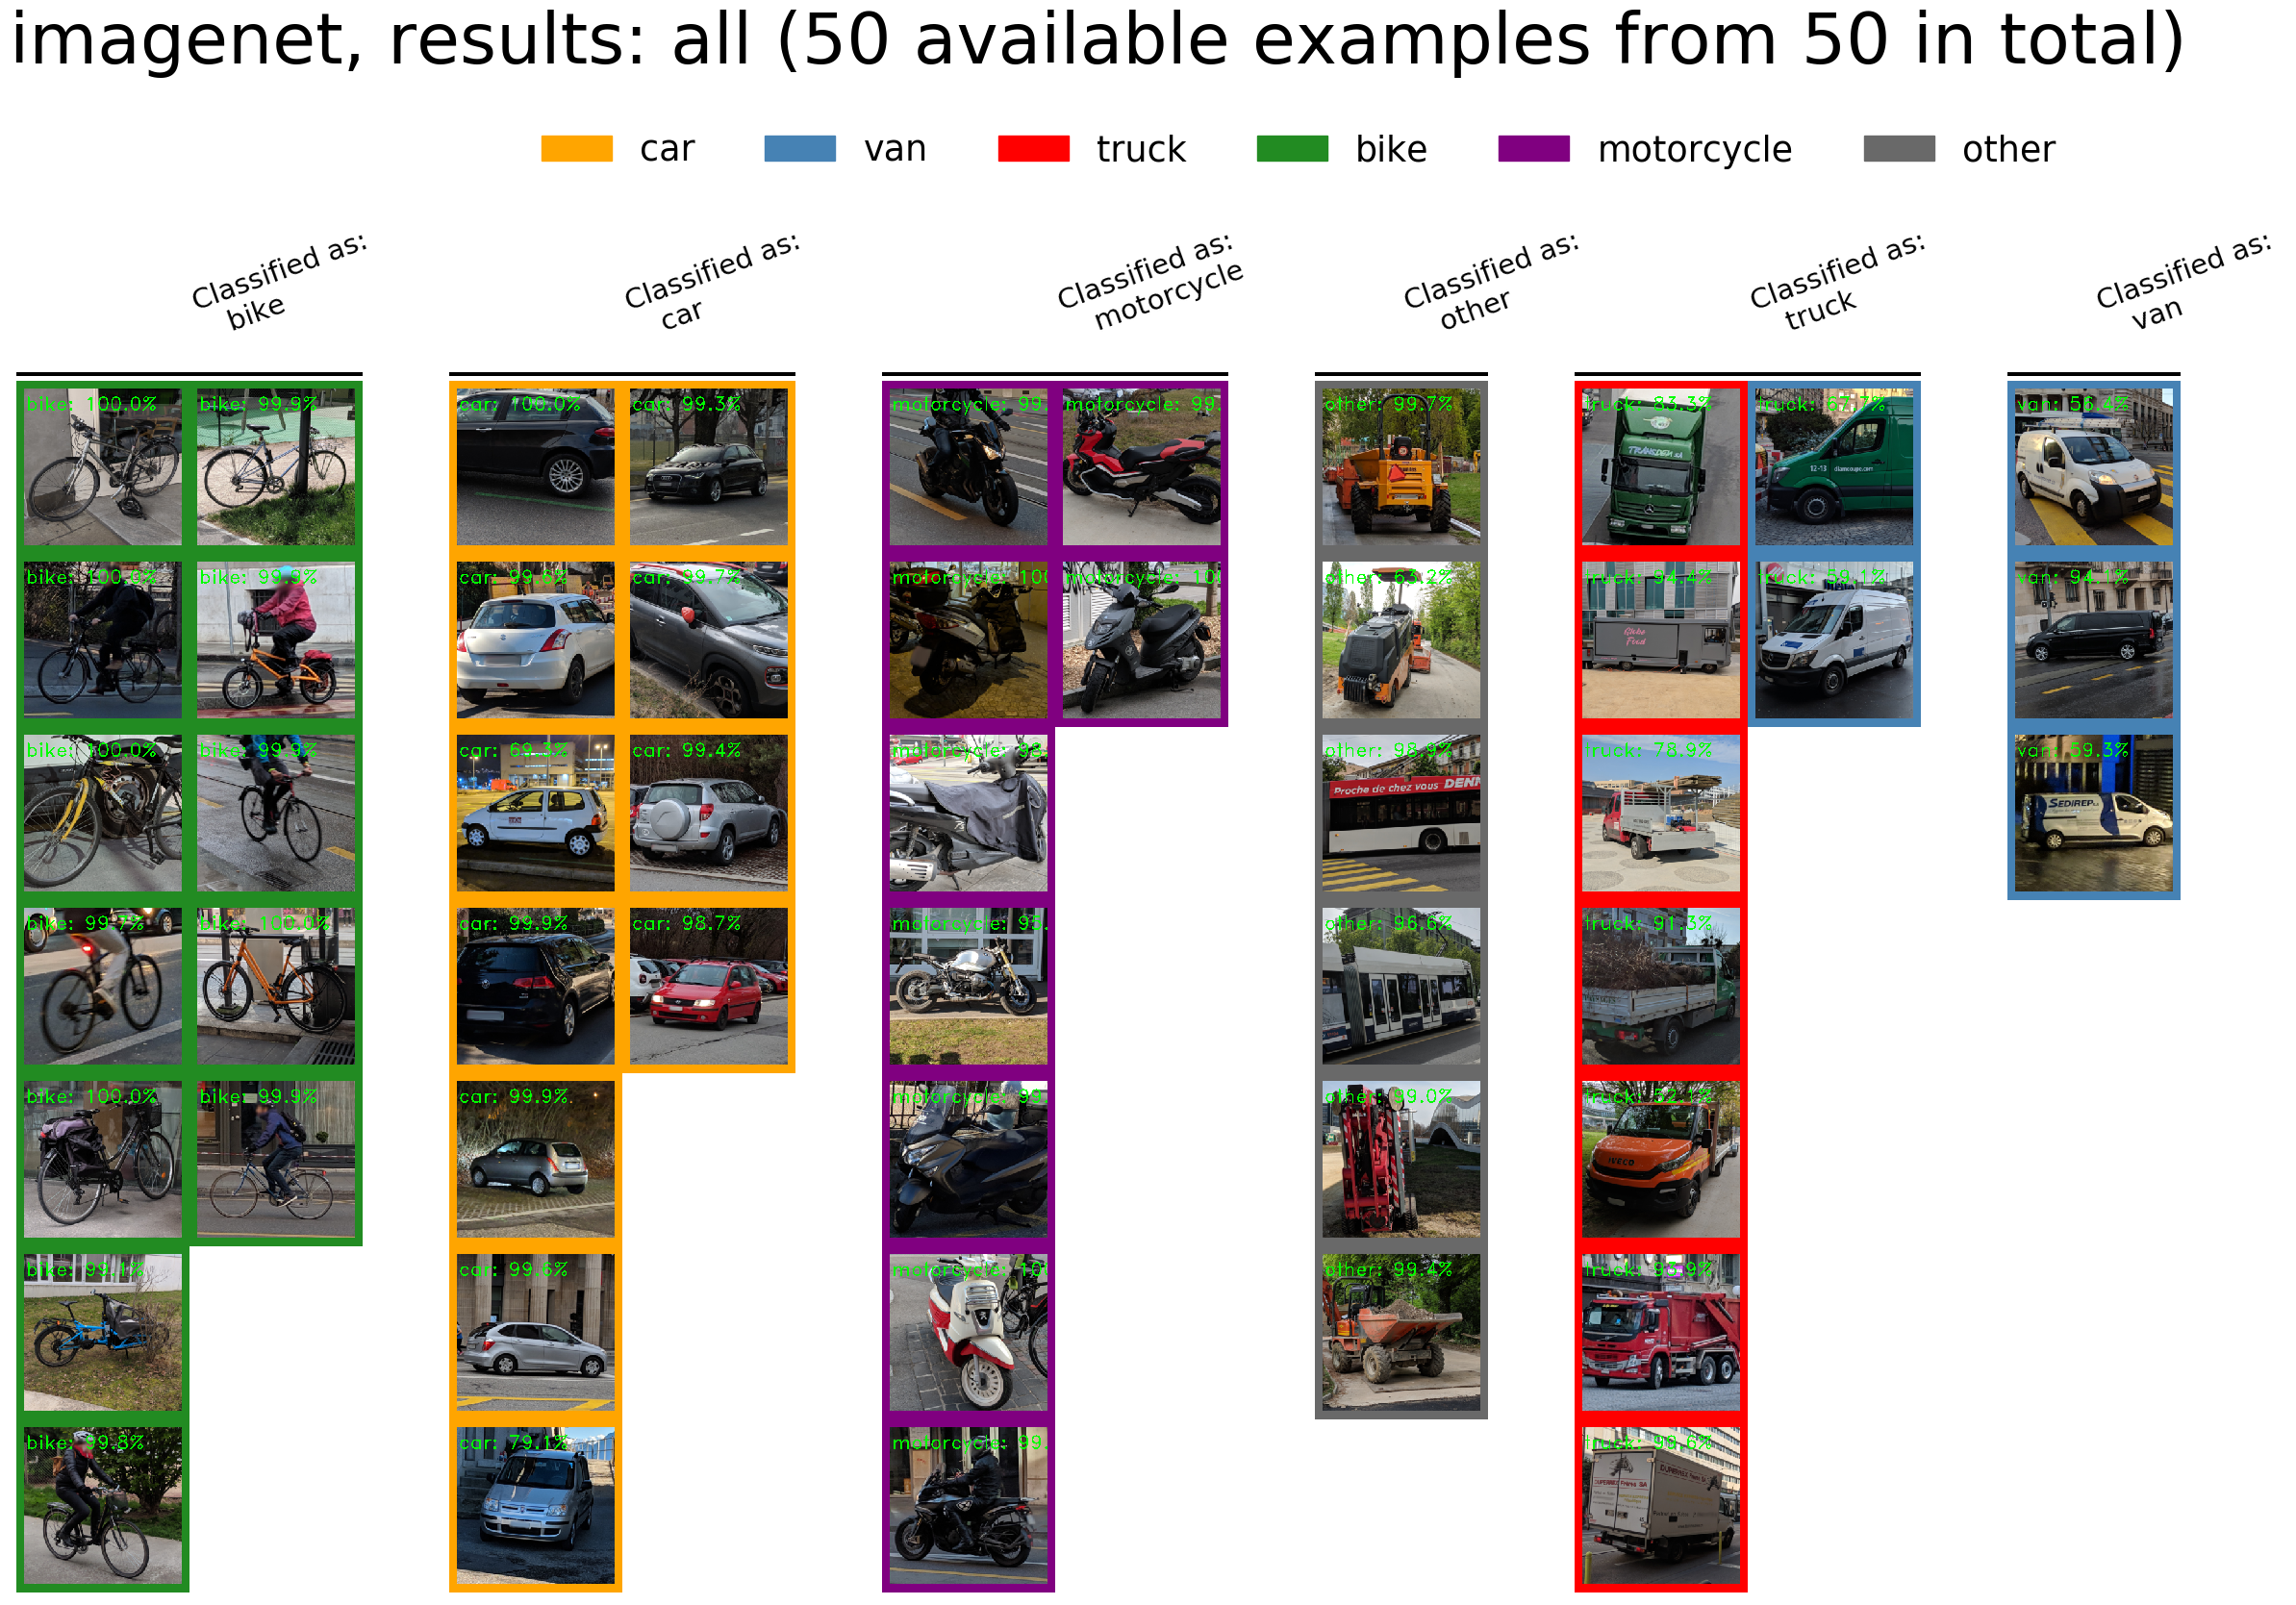

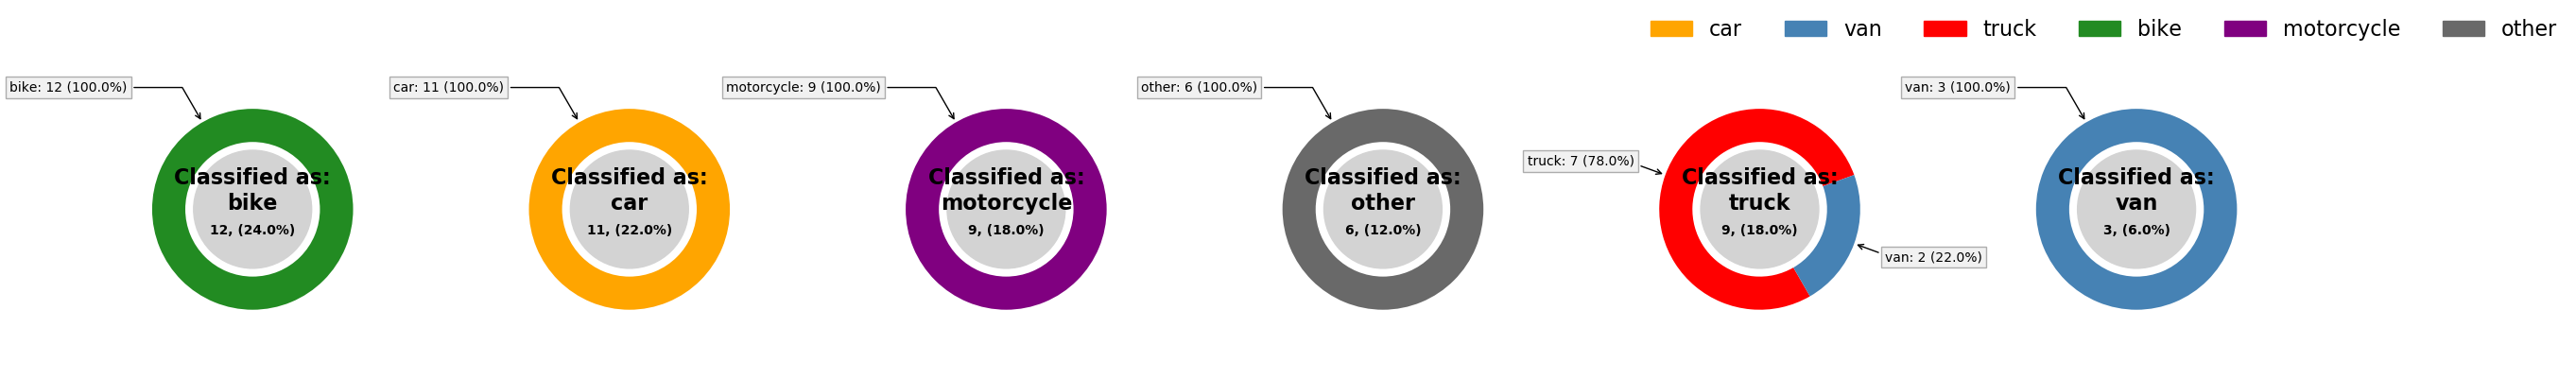

In [11]:
# FIND AND LOAD THE DATA, 

# .. select model_ID of the best performing model from the above table, 
model_ID = best_performing_model_on_each_plot.sort_values("model_acc_valid", ascending=False).model_ID.iloc[0]

# .. load model_predictions_dict
os.chdir(PATH_results)
with open(f"{task_name}__{module_names[0]}__{dataset_name}__model_predictions_dict.p", 'rb') as file: # wb - write binary,
    model_predictions_dict  = pickle.load(file) 

# .. load model_hist_dict
with open(f"{task_name}__{module_names[0]}__{dataset_name}__model_history_dict.p", 'rb') as file: # wb - write binary,
    model_history_dict  = pickle.load(file) 
   
    
    
# PLOTS
    
# .. plot loss and accuracy values history over epoch
test_acc_results = model_predictions_dict[model_ID]["test"]['acc_restuls_and_params']["model_acc_test"]        
plot_NN_loss_acc(
    title=f"Best Performing Model, Acc for test data = {str(np.round(test_acc_results,3))}",
    model_history_df=model_history_dict[model_ID]['model_history'], 
    n_mean=3,
    figsize=(6,3),
    top=0.75
)

# .. plot loss and accuracy values history over epoch
plot_examples_with_predictions_and_proba_gamma( 
    model_ID=model_ID,
    model_predictions_dict= model_predictions_dict, 
    module_name=module_names[0], 
    dataset_name=dataset_name,                              
    subset_name=["test"], # denotes test predicitons made for test_subset_names
    img_batch_subset_names=test_subset_names, 
    path_to_raw_img_batch=PATH_raw,
    class_colors=class_colors,
    make_plot_with_img_examples=True, # use False, to have only pie charts with classyfication summary                                         
    max_img_per_col=7,
    plot_classyfication_summary=True
)